In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Full unprocessed dataset
X_train = pd.read_csv("/datasets/sberbank-russian-housing-market/train.csv", index_col=0)
df_macro = pd.read_csv("/datasets/sberbank-russian-housing-market/macro.csv")

In [ ]:
# dropping na's and processing ONLY for the forward stepwise
X_train.dropna(inplace=True)
X_train.reset_index(inplace=True)
X_train.drop(columns=["id"], inplace=True)
X_train = X_train.select_dtypes(include=np.number)

In [ ]:
y_train = X_train[["price_doc"]]
X_train = X_train.drop("price_doc", axis = 1)

In [ ]:
X_train_sample = X_train[["full_sq", "life_sq","floor"]].fillna(0).sample(5000)
y_train_sample = y_train.loc[X_train_sample.index]

In [2]:
# Entire normalized and cleaned dataset
X_train = pd.read_csv("../Data/df_train_vvfinal").drop("Unnamed: 0", axis = 1)
y_train = pd.read_csv("../Data/y_train_vfinal").drop("Unnamed: 0", axis = 1)
X_train_normalize = (X_train - X_train.mean())/X_train.std()
y_train_normalize = (y_train - y_train.mean())/y_train.std()

X_val = pd.read_csv("../Data/df_val_vvfinal").drop("Unnamed: 0", axis = 1)
X_val.at[591, "build_year"] = 2009
y_val = pd.read_csv("../Data/y_val_vfinal").drop("Unnamed: 0", axis = 1)
X_val_normalize = (X_val - X_train.mean())/X_train.std()
y_val_normalize = (y_val - y_train.mean())/y_train.std()

X_test = pd.read_csv("../Data/df_test_vvfinal").drop("Unnamed: 0", axis = 1)
y_test = pd.read_csv("../Data/y_test_vfinal").drop("Unnamed: 0", axis = 1)
X_test_normalize = (X_test - X_train.mean())/X_train.std()
y_test_normalize = (y_test - y_train.mean())/y_train.std()

## Neural Network

In [3]:
class NeuralNetwork(): 
    def fit(self, X, y, n_hidden, nodes, activations, lr, validation_X, validation_y, batch_size = 0):
        self._lr = lr
        self._X = X.values
        self._y = y.values
        self._n_hidden = n_hidden
        self._nodes = nodes
        self._weights = self._generate_weights()
        self._biases = self._generate_bias()
        self._activations = activations
        self._forward_inputs = []
        self._val_X = validation_X.values
        self._val_y = validation_y.values
        self._batch_size = batch_size
        

        return self._train()
    
    def predict(self, X):
        pred = X
        weights = self._weights
        biases = self._biases
        activations = self._activations[1:-1]
    
        for idx, layer in enumerate(weights):
            if idx == (len(weights) - 1):
                pred = (pred @ layer) + biases[idx].T,
            else:
                weight_output = (pred @ layer) + biases[idx].T
                pred = self._activation(data = weight_output, activation = activations[idx])

        return pred[0]
        
    def _activation(self, data, activation = "relu"):
        if activation == "relu":
            def relu(data):
                return np.array([max(0,i) for i in data]).reshape(data.shape)
            return np.apply_along_axis(relu, 1, data)
        if activation == "sigmoid":
            def sigmoid(data):
                return (1/(1 + np.exp(-data))).reshape(data.shape)
            return np.apply_along_axis(sigmoid, 1, data)
    
    def _der_activation(self, points, activation = "relu"):
        if activation == "relu":
            def d_relu(point):
                return np.array([0 if y <= 0 else 1 for y in point])
            return np.apply_along_axis(d_relu, 1, points)
        if activation == "sigmoid":
            ## todo
            return
    
    def _loss_function(self, ypred, loss = "l2"):
        y = self._val_y
        if loss == "mse":
            return ((ypred - y) ** 2).mean()
        if loss == "l2":
            return (((ypred - y) ** 2)/2).mean()
    
    def _loss_jacobian(self, ypred, loss = "l2"):
        if self._batch_size > 0:
            y = self._batchy
        else:
            y = self._y
        if loss == "l2":
            return (ypred - y)/(len(ypred))
    
    def _generate_weights(self):
        hidden_weights = []
        nodes = self._nodes
        for idx in range(1,len(nodes)):
            hidden_weights.append(0.1 * np.random.randn(nodes[idx -1], nodes[idx]))
            #hidden_weights.append(0.01 *np.random.randn(nodes[idx -1], nodes[idx]))

        return hidden_weights
    
    def _generate_bias(self):
        hidden_layers = []
        nodes = self._nodes
        for i in range(self._n_hidden + 1):
            hidden_layers.append(np.zeros((nodes[i + 1], 1)))
        return hidden_layers
    
    
    def _forward_propagation(self):
        """
        Suppose 2 observations
        
        Suppose previous layer is 3 nodes
        Suppose current layer is 2 nodes
        
        prev shape (2,3)
        prev = ob1 [prev_node_1 val, prev_node_2 val, prev_node_3 val]
               ob2 [prev_node_1 val, prev_node_2 val, prev_node_3 val]
               
        layer shape (3,2)
        layer = [weight for current_node_1 for prev_node_1, weight for current_node_2 for prev_node_1]
                [weight for current_node_1 for prev_node_2, weight for current_node_2 for prev_node_2]
                [weight for current_node_1 for prev_node_3, weight for current_node_2 for prev_node_3]
                
        output shape (2,2) # since 2 observations and 2 layers
        output = ob1 [current_node_1 val, current_node_2 val]
                 ob2 [current_node_1 val, current_node_2 val]
                 
        Then for bias in current layer it is (2,1) since 2 nodes in current layer
        
        So for each row in output we add the bias row wise and apply the activation function to each row
        
        prev <- ouput
        
        Move onto next layer...
        """
        if self._batch_size > 0:
            prev = self._batchX
        else:
            prev = self._X
        weights = self._weights
        biases = self._biases
        activations = self._activations[1:-1]
    
        for idx, layer in enumerate(weights):
            if idx == (len(weights) - 1):
                self._forward_inputs.append((prev, None))
                prev = (prev @ layer) + biases[idx].T,
            else:
                weight_output = (prev @ layer) + biases[idx].T
                self._forward_inputs.append((prev, weight_output))
                prev = self._activation(data = weight_output, activation = activations[idx])

        return prev
    
    def _backward_propagation(self, ypred):
            
        j = self._loss_jacobian(ypred)
                
        for i in range(len(self._forward_inputs)-1, -1, -1):
            if i != (len(self._forward_inputs) - 1):
                # activation func on all layers except the last
                der_acti = self._der_activation(self._forward_inputs[i][1])
                j = np.multiply(j,der_acti)

            x = self._forward_inputs[i][0]

            jw = x.T.dot(j)

            b = np.ones((j.shape[0],1))
            jb = j.T.dot(b)
            
            j = j.dot(self._weights[i].T)
            
            self._weights[i] -= self._lr * jw
            self._biases[i] -= self._lr * jb
            
        self._forward_inputs = []        
    
    def _train(self):
        min_loss = old_loss = np.inf
        losses = []
        mses = []
        tol = 0.0001
        terminate_count = anneal_count = step_count = 0
        while True:
            if self._batch_size > 0:
                X_index = np.arange(self._X.shape[0])
                np.random.shuffle(X_index)
                batch_index = X_index[:self._batch_size]
                self._batchX = self._X[batch_index,:]
                self._batchy = self._y[batch_index,:]
            
            batched_out = self._forward_propagation()
            validation_out = self.predict(self._val_X)
                
            loss = self._loss_function(validation_out)
            mse = self._loss_function(validation_out, loss = "mse")
            print("\nloss:")
            print(loss)
            print("mse:")
            print(mse)
            if loss <= min_loss:
                min_loss = loss
                terminate_count = anneal_count = 0
            if loss <= old_loss:
                anneal_count = 0
            else:
                terminate_count += 1
                anneal_count += 1
                print("INCREASE IN LOSS")
                if anneal_count >= 2:
                    anneal_count = 0
                    self._lr = self._lr / 2
                    print("Decreasing learning rate. New rate is " + str(self._lr))
                if terminate_count > 20:
                    break
            if step_count > 30:
                self._lr = self._lr * 0.9
                print("Annealing learning rate. New rate is " + str(self._lr))
                step_count = 0
            if self._lr < tol:
                break
            
            losses.append(loss)
            mses.append(mse)
            self._backward_propagation(batched_out[0])
            old_loss = loss
            step_count += 1
            
        return losses, mses

In [ ]:
INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.5
nodes = [INPUT_SIZE,50,OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]

nn = NeuralNetwork()

losses, mses = nn.fit(X = X_train_normalize,
       y = y_train_normalize,
       n_hidden = len(nodes) - 2,
       nodes = nodes,
       activations = activations,
       lr = LEARNING_RATE,
       validation_X = X_val_normalize,
       validation_y = y_val_normalize,
       batch_size = 1000)

In [ ]:
# Loss and MSE Plot
plt.plot(range(0,len(mses)), mses, color='red', linewidth=2, label="mse")
plt.plot(range(0,len(mses)), losses, color='blue', linewidth=2, linestyle='dashed', label="loss")
plt.legend()

### GRID SEARCH

In [ ]:
# GRID SEARCH
INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.5


batch_size_param = [64, 128, 512, 1024, 2048, 5000, 10000]
width_param = [34, 50, 75, 100]
depth_param = [1, 5, 7, 8, 10]

for batch in batch_size_param:
    for width in width_param:
        for depth in depth_param:
            
            min_losses = []
            min_mses = []
            
            for i in range(0,5):
                nodes = [INPUT_SIZE] + [width for i in range(depth)] + [OUTPUT_SIZE]
                activations = ["relu" for i in range(len(nodes))]

                nn = NeuralNetwork()

                losses, mses = nn.fit(X = X_train_normalize,
                       y = y_train_normalize,
                       n_hidden = len(nodes) - 2,
                       nodes = nodes,
                       activations = activations,
                       lr = LEARNING_RATE,
                       validation_X = X_val_normalize,
                       validation_y = y_val_normalize,
                       batch_size = batch)

                print((batch, width, depth))
                print(min(losses), min(mses))
                min_losses.append(min(losses))
                min_mses.append(min(mses))
                
                plt.figure()
                plt.plot(range(0,len(mses)), mses, color='red', linewidth=2, label="mse")
                plt.plot(range(0,len(mses)), losses, color='blue', linewidth=2, linestyle='dashed', label="loss")
                plt.legend()
            
            print(mean(min_losses), mean(mses)) 

In [4]:
# 1x34 (batch = 0)
batch = 0
width = 34
depth = 1

INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.5

nodes = [INPUT_SIZE] + [width for i in range(depth)] + [OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]
nn = NeuralNetwork()

losses, mses = nn.fit(X = X_train_normalize,
                      y = y_train_normalize,
                      n_hidden = len(nodes) - 2,
                      nodes = nodes,
                      activations = activations,
                      lr = LEARNING_RATE,
                      validation_X = X_val_normalize,
                      validation_y = y_val_normalize,
                      batch_size = batch)

# RESULTS
## loss = 0.186
## mse = 0.373


loss:
0.5592583900575974
mse:
1.1185167801151947

loss:
0.470959105362611
mse:
0.941918210725222

loss:
0.36607302163125255
mse:
0.7321460432625051

loss:
0.32171368943625767
mse:
0.6434273788725153

loss:
0.32705662344866715
mse:
0.6541132468973343
INCREASE IN LOSS

loss:
0.41118094178590003
mse:
0.8223618835718001
INCREASE IN LOSS
Decreasing learning rate. New rate is 0.25

loss:
0.27432348799043665
mse:
0.5486469759808733

loss:
0.26533416093925744
mse:
0.5306683218785149

loss:
0.2624632084523206
mse:
0.5249264169046411

loss:
0.26033241888279524
mse:
0.5206648377655905

loss:
0.2586388920649063
mse:
0.5172777841298126

loss:
0.2572039320000708
mse:
0.5144078640001416

loss:
0.2559565730212264
mse:
0.5119131460424527

loss:
0.25482184382734857
mse:
0.5096436876546971

loss:
0.25374504305455026
mse:
0.5074900861091005

loss:
0.25272065849575126
mse:
0.5054413169915025

loss:
0.2517433359905161
mse:
0.5034866719810323

loss:
0.25081003505651484
mse:
0.5016200701130297

loss:
0.24993


loss:
0.20666417585995034
mse:
0.4133283517199007
Annealing learning rate. New rate is 0.14762250000000005

loss:
0.20653726220442023
mse:
0.41307452440884046

loss:
0.2064110368862456
mse:
0.4128220737724912

loss:
0.20628566099177068
mse:
0.41257132198354135

loss:
0.2061612445781949
mse:
0.4123224891563898

loss:
0.20603811908469202
mse:
0.41207623816938405

loss:
0.2059160403680212
mse:
0.4118320807360424

loss:
0.20579334124927423
mse:
0.41158668249854846

loss:
0.20567243479347663
mse:
0.41134486958695327

loss:
0.2055522652487583
mse:
0.4111045304975166

loss:
0.20543256175385136
mse:
0.4108651235077027

loss:
0.20531307785690273
mse:
0.41062615571380545

loss:
0.20519519067969008
mse:
0.41039038135938016

loss:
0.2050772574182253
mse:
0.4101545148364506

loss:
0.2049598208076086
mse:
0.4099196416152172

loss:
0.20484516049527415
mse:
0.4096903209905483

loss:
0.20472938143967176
mse:
0.4094587628793435

loss:
0.20461494450954498
mse:
0.40922988901908997

loss:
0.20450092662674


loss:
0.19444638011921148
mse:
0.38889276023842295
Annealing learning rate. New rate is 0.08716961002500004

loss:
0.19440732154819979
mse:
0.38881464309639957

loss:
0.19436661241617978
mse:
0.38873322483235956

loss:
0.19432497970761384
mse:
0.3886499594152277

loss:
0.1942853462731682
mse:
0.3885706925463364

loss:
0.1942434355728333
mse:
0.3884868711456666

loss:
0.19420525105738026
mse:
0.3884105021147605

loss:
0.19416471117340997
mse:
0.38832942234681994

loss:
0.19412696486956743
mse:
0.38825392973913486

loss:
0.19408743451361513
mse:
0.38817486902723025

loss:
0.19404952864691427
mse:
0.38809905729382854

loss:
0.19401176106583468
mse:
0.38802352213166935

loss:
0.19397249557635377
mse:
0.38794499115270753

loss:
0.19393494219649854
mse:
0.3878698843929971

loss:
0.19389521654001535
mse:
0.3877904330800307

loss:
0.19385779743013018
mse:
0.38771559486026036

loss:
0.19381898680775247
mse:
0.38763797361550495

loss:
0.1937810748751132
mse:
0.3875621497502264

loss:
0.19374339


loss:
0.1899592136439011
mse:
0.3799184272878022
Annealing learning rate. New rate is 0.051472783023662275

loss:
0.18994279256193344
mse:
0.3798855851238669

loss:
0.18992414368480107
mse:
0.37984828736960213

loss:
0.18990651375505704
mse:
0.3798130275101141

loss:
0.18988847216116822
mse:
0.37977694432233644

loss:
0.18987083611602593
mse:
0.37974167223205185

loss:
0.18985353310744685
mse:
0.3797070662148937

loss:
0.1898347538588844
mse:
0.3796695077177688

loss:
0.18981728535897
mse:
0.37963457071794

loss:
0.18979816814168649
mse:
0.37959633628337297

loss:
0.18978024067634655
mse:
0.3795604813526931

loss:
0.18976356565398733
mse:
0.37952713130797466

loss:
0.1897449482022882
mse:
0.3794898964045764

loss:
0.18972814112187578
mse:
0.37945628224375155

loss:
0.18970898134325084
mse:
0.3794179626865017

loss:
0.18969181693070564
mse:
0.3793836338614113

loss:
0.189674421814986
mse:
0.379348843629972

loss:
0.18965720504331945
mse:
0.3793144100866389

loss:
0.1896397337677643
mse


loss:
0.18792552620708464
mse:
0.3758510524141693
Annealing learning rate. New rate is 0.03039416364764234

loss:
0.1879169554936491
mse:
0.3758339109872982

loss:
0.18790824836189957
mse:
0.37581649672379913

loss:
0.18789980666292738
mse:
0.37579961332585476

loss:
0.18789108993402337
mse:
0.37578217986804674

loss:
0.1878822898515968
mse:
0.3757645797031936

loss:
0.18787406162836054
mse:
0.3757481232567211

loss:
0.18786554990369256
mse:
0.3757310998073851

loss:
0.1878564586363386
mse:
0.3757129172726772

loss:
0.18784835901528124
mse:
0.3756967180305625

loss:
0.1878395979737422
mse:
0.3756791959474844

loss:
0.18783074330825195
mse:
0.3756614866165039

loss:
0.18782247155485654
mse:
0.3756449431097131

loss:
0.18781379715217092
mse:
0.37562759430434184

loss:
0.18780466778127491
mse:
0.37560933556254983

loss:
0.18779657854253093
mse:
0.37559315708506186

loss:
0.18778747700949572
mse:
0.37557495401899144

loss:
0.18777883637713516
mse:
0.3755576727542703

loss:
0.1877705723448


loss:
0.18684160169848063
mse:
0.37368320339696126

loss:
0.18683638846226253
mse:
0.37367277692452505

loss:
0.18683185609728972
mse:
0.37366371219457944

loss:
0.18682674850390432
mse:
0.37365349700780864

loss:
0.18682220202321015
mse:
0.3736444040464203

loss:
0.1868170546105399
mse:
0.3736341092210798

loss:
0.1868124216740702
mse:
0.3736248433481404

loss:
0.1868074235274127
mse:
0.3736148470548254

loss:
0.18680265439673183
mse:
0.37360530879346365

loss:
0.1867978548033689
mse:
0.3735957096067378

loss:
0.1867931053860318
mse:
0.3735862107720636

loss:
0.1867881747975928
mse:
0.3735763495951856

loss:
0.18678367642866878
mse:
0.37356735285733755

loss:
0.1867783806752734
mse:
0.3735567613505468

loss:
0.18677365110707245
mse:
0.3735473022141449

loss:
0.18676901502258705
mse:
0.3735380300451741

loss:
0.1867640243852845
mse:
0.373528048770569

loss:
0.18675919542784764
mse:
0.37351839085569527

loss:
0.18675437031610934
mse:
0.37350874063221867

loss:
0.18674977457054376
mse:



loss:
0.1862394202535163
mse:
0.3724788405070326

loss:
0.18623686032836986
mse:
0.3724737206567397

loss:
0.18623402302189246
mse:
0.3724680460437849

loss:
0.1862311127432736
mse:
0.3724622254865472

loss:
0.18622851088872705
mse:
0.3724570217774541

loss:
0.18622571966150386
mse:
0.3724514393230077

loss:
0.18622282234717022
mse:
0.37244564469434044

loss:
0.18622011112327486
mse:
0.3724402222465497

loss:
0.18621735508568343
mse:
0.37243471017136687

loss:
0.18621460554518238
mse:
0.37242921109036475

loss:
0.18621202110861781
mse:
0.37242404221723563

loss:
0.18620911262087836
mse:
0.3724182252417567

loss:
0.1862065529554027
mse:
0.3724131059108054

loss:
0.18620369468150877
mse:
0.37240738936301754

loss:
0.18620079026327094
mse:
0.3724015805265419

loss:
0.18619819794943326
mse:
0.37239639589886653

loss:
0.1861954342594955
mse:
0.372390868518991

loss:
0.18619253765216812
mse:
0.37238507530433623

loss:
0.18618994055704957
mse:
0.37237988111409914

loss:
0.18618692917713167
m


loss:
0.18590492251370383
mse:
0.37180984502740766

loss:
0.18590340468271574
mse:
0.3718068093654315

loss:
0.18590189315129288
mse:
0.37180378630258576

loss:
0.18590049215671547
mse:
0.37180098431343095

loss:
0.18589893938323115
mse:
0.3717978787664623

loss:
0.1858974081530747
mse:
0.3717948163061494

loss:
0.18589599192164982
mse:
0.37179198384329964

loss:
0.18589441278613847
mse:
0.37178882557227694

loss:
0.18589298400291474
mse:
0.37178596800582947

loss:
0.1858914296114604
mse:
0.3717828592229208

loss:
0.18589000272098127
mse:
0.37178000544196255

loss:
0.1858885293105575
mse:
0.371777058621115

loss:
0.1858868675596502
mse:
0.3717737351193004

loss:
0.18588553177180048
mse:
0.37177106354360095

loss:
0.18588395075560984
mse:
0.3717679015112197

loss:
0.18588235297675312
mse:
0.37176470595350625

loss:
0.18588080477770608
mse:
0.37176160955541215

loss:
0.1858793772270666
mse:
0.3717587544541332

loss:
0.1858777775654278
mse:
0.3717555551308556

loss:
0.18587629737996714
m


loss:
0.1857128325305905
mse:
0.371425665061181

loss:
0.1857118880449912
mse:
0.3714237760899824

loss:
0.18571096906135512
mse:
0.37142193812271024

loss:
0.18571011760555642
mse:
0.37142023521111284

loss:
0.18570918334949407
mse:
0.37141836669898814

loss:
0.1857082504816035
mse:
0.371416500963207

loss:
0.1857073431704974
mse:
0.3714146863409948

loss:
0.18570639011844356
mse:
0.3714127802368871

loss:
0.18570552912142116
mse:
0.3714110582428423

loss:
0.18570458495259948
mse:
0.37140916990519895

loss:
0.1857036465461308
mse:
0.3714072930922616

loss:
0.18570272098819673
mse:
0.37140544197639347

loss:
0.1857018483705251
mse:
0.3714036967410502

loss:
0.18570093261554146
mse:
0.37140186523108293

loss:
0.18570000258097225
mse:
0.3714000051619445

loss:
0.1856990683575071
mse:
0.3713981367150142

loss:
0.18569817694227317
mse:
0.37139635388454634

loss:
0.1856972113819521
mse:
0.3713944227639042

loss:
0.1856963771882978
mse:
0.3713927543765956

loss:
0.18569541213756893
mse:
0.3


loss:
0.18560287720025664
mse:
0.3712057544005133

loss:
0.1856023395645571
mse:
0.3712046791291142

loss:
0.1856018278241905
mse:
0.371203655648381

loss:
0.18560131349046158
mse:
0.37120262698092316

loss:
0.18560082822816137
mse:
0.37120165645632275

loss:
0.18560033986838517
mse:
0.37120067973677034

loss:
0.1855997931704596
mse:
0.3711995863409192

loss:
0.18559928322723854
mse:
0.3711985664544771

loss:
0.18559876543599166
mse:
0.3711975308719833

loss:
0.18559826899637172
mse:
0.37119653799274344

loss:
0.18559775519660818
mse:
0.37119551039321635

loss:
0.18559724331235405
mse:
0.3711944866247081

loss:
0.18559674589616165
mse:
0.3711934917923233

loss:
0.1855962078908883
mse:
0.3711924157817766

loss:
0.18559570729036
mse:
0.37119141458072

loss:
0.18559517768443234
mse:
0.3711903553688647

loss:
0.185594715447152
mse:
0.371189430894304

loss:
0.18559417269855485
mse:
0.3711883453971097

loss:
0.18559369246889915
mse:
0.3711873849377983

loss:
0.18559314164972124
mse:
0.37118


loss:
0.1855388920244402
mse:
0.3710777840488804

loss:
0.18553858728253128
mse:
0.37107717456506256

loss:
0.1855383038815982
mse:
0.3710766077631964

loss:
0.18553799729020426
mse:
0.3710759945804085

loss:
0.18553769698630873
mse:
0.37107539397261746

loss:
0.1855374023985545
mse:
0.371074804797109

loss:
0.18553710251937622
mse:
0.37107420503875244

loss:
0.18553679434702855
mse:
0.3710735886940571

loss:
0.18553649991794094
mse:
0.3710729998358819

loss:
0.18553619881244157
mse:
0.37107239762488314

loss:
0.18553589023802658
mse:
0.37107178047605316

loss:
0.18553559301175207
mse:
0.37107118602350414

loss:
0.18553529196794158
mse:
0.37107058393588316

loss:
0.18553500291207592
mse:
0.37107000582415184

loss:
0.18553468700878276
mse:
0.3710693740175655

loss:
0.18553437014800064
mse:
0.3710687402960013

loss:
0.18553409461605175
mse:
0.3710681892321035

loss:
0.18553378013407612
mse:
0.37106756026815224

loss:
0.18553348250591012
mse:
0.37106696501182024

loss:
0.1855331763980882


loss:
0.18550067558326636
mse:
0.3710013511665327

loss:
0.1855005035487108
mse:
0.3710010070974216

loss:
0.18550032335565578
mse:
0.37100064671131155

loss:
0.1855001353015595
mse:
0.371000270603119

loss:
0.1854999581689042
mse:
0.3709999163378084

loss:
0.18549977750514773
mse:
0.37099955501029547

loss:
0.18549959074256195
mse:
0.3709991814851239

loss:
0.18549941578942697
mse:
0.37099883157885394

loss:
0.1854992370730343
mse:
0.3709984741460686

loss:
0.18549905334832206
mse:
0.3709981066966441

loss:
0.18549887255002215
mse:
0.3709977451000443

loss:
0.1854986938444503
mse:
0.3709973876889006

loss:
0.18549851553269694
mse:
0.3709970310653939

loss:
0.18549833163903953
mse:
0.37099666327807906

loss:
0.1854981529307332
mse:
0.3709963058614664

loss:
0.18549797542170088
mse:
0.37099595084340176

loss:
0.1854977960675466
mse:
0.3709955921350932

loss:
0.18549760623279432
mse:
0.37099521246558864

loss:
0.18549743430139404
mse:
0.3709948686027881

loss:
0.18549724971191792
mse:
0


loss:
0.1854779104275613
mse:
0.3709558208551226

loss:
0.1854778058472795
mse:
0.370955611694559

loss:
0.18547770022707957
mse:
0.37095540045415915

loss:
0.18547759638438727
mse:
0.37095519276877453

loss:
0.18547748561731245
mse:
0.3709549712346249

loss:
0.1854773831925552
mse:
0.3709547663851104

loss:
0.18547727752631993
mse:
0.37095455505263986

loss:
0.18547716839252992
mse:
0.37095433678505985

loss:
0.18547706362208652
mse:
0.37095412724417304

loss:
0.18547695733821049
mse:
0.37095391467642097

loss:
0.18547685233406042
mse:
0.37095370466812083

loss:
0.18547674328829533
mse:
0.37095348657659066

loss:
0.18547663819530136
mse:
0.3709532763906027

loss:
0.1854765314102412
mse:
0.3709530628204824

loss:
0.18547642562866015
mse:
0.3709528512573203

loss:
0.18547631673676515
mse:
0.3709526334735303

loss:
0.18547621359599817
mse:
0.37095242719199634

loss:
0.18547610244668603
mse:
0.37095220489337205

loss:
0.18547600071014095
mse:
0.3709520014202819

loss:
0.18547589448194823


loss:
0.18546459256389347
mse:
0.37092918512778694

loss:
0.1854645296547118
mse:
0.3709290593094236

loss:
0.18546446941777667
mse:
0.37092893883555333

loss:
0.18546440599898295
mse:
0.3709288119979659

loss:
0.18546434494349512
mse:
0.37092868988699024

loss:
0.18546427925013642
mse:
0.37092855850027284

loss:
0.18546422074512842
mse:
0.37092844149025683

loss:
0.1854641559740914
mse:
0.3709283119481828

loss:
0.18546409607261644
mse:
0.37092819214523287

loss:
0.18546403264139083
mse:
0.37092806528278166

loss:
0.1854639711281015
mse:
0.370927942256203

loss:
0.18546390963078496
mse:
0.3709278192615699

loss:
0.1854638457137495
mse:
0.370927691427499

loss:
0.18546378429915517
mse:
0.37092756859831033

loss:
0.18546372165290892
mse:
0.37092744330581784

loss:
0.1854636602522264
mse:
0.3709273205044528

loss:
0.1854635957935596
mse:
0.3709271915871192

loss:
0.1854635382130869
mse:
0.3709270764261738

loss:
0.18546347149696127
mse:
0.37092694299392254

loss:
0.1854634090954794
mse:


loss:
0.18545675323659494
mse:
0.3709135064731899

loss:
0.18545671740286143
mse:
0.37091343480572286

loss:
0.1854566811114377
mse:
0.3709133622228754

loss:
0.18545664460998404
mse:
0.3709132892199681

loss:
0.1854566073833181
mse:
0.3709132147666362

loss:
0.18545657021934217
mse:
0.37091314043868434

loss:
0.18545653513206858
mse:
0.37091307026413717

loss:
0.1854564974355243
mse:
0.3709129948710486

loss:
0.18545646137495456
mse:
0.3709129227499091

loss:
0.18545642466028908
mse:
0.37091284932057816

loss:
0.1854563865198112
mse:
0.3709127730396224

loss:
0.18545635250768427
mse:
0.37091270501536855

loss:
0.18545631367925047
mse:
0.37091262735850095

loss:
0.18545627790958322
mse:
0.37091255581916643

loss:
0.1854562417073383
mse:
0.3709124834146766

loss:
0.18545620471318702
mse:
0.37091240942637405

loss:
0.18545616903843845
mse:
0.3709123380768769

loss:
0.18545613081169718
mse:
0.37091226162339436

loss:
0.18545609504294416
mse:
0.3709121900858883

loss:
0.18545605824751663


In [5]:
# Predict on Train
predictions = nn.predict(X_test_normalize)
test_mse = ((predictions - y_test_normalize) ** 2).mean()
test_mse

price_doc    1.07405
dtype: float64

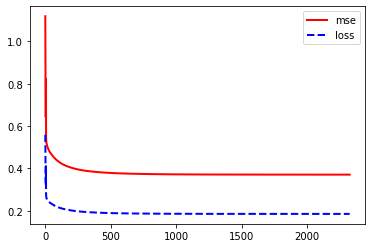

In [6]:
# Loss and MSE Plot
plt.plot(range(0,len(mses)), mses, color='red', linewidth=2, label="mse")
plt.plot(range(0,len(mses)), losses, color='blue', linewidth=2, linestyle='dashed', label="loss")
plt.legend()

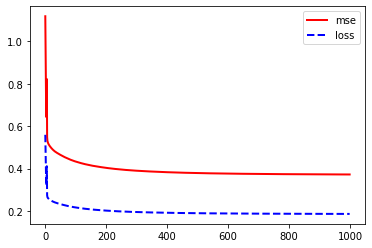

In [13]:
mses2 = mses[:1000]
losses2 = losses[:1000]
# Loss and MSE Plot
plt.plot(range(0,len(mses2)), mses2, color='red', linewidth=2, label="mse")
plt.plot(range(0,len(losses2)), losses2, color='blue', linewidth=2, linestyle='dashed', label="loss")
plt.legend()

In [14]:
# 3x34 (batch = 0)
batch = 0
width = 34
depth = 1

INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.6

nodes = [INPUT_SIZE] + [width for i in range(depth)] + [OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]
nn = NeuralNetwork()

losses, mses = nn.fit(X = X_train_normalize,
                      y = y_train_normalize,
                      n_hidden = len(nodes) - 2,
                      nodes = nodes,
                      activations = activations,
                      lr = LEARNING_RATE,
                      validation_X = X_val_normalize,
                      validation_y = y_val_normalize,
                      batch_size = batch)

# RESULTS
## loss = 
## mse = 


loss:
0.43847086715695727
mse:
0.8769417343139145

loss:
0.37841860547435013
mse:
0.7568372109487003

loss:
0.34090287739886393
mse:
0.6818057547977279

loss:
0.3105469400346793
mse:
0.6210938800693586

loss:
0.2873676950297792
mse:
0.5747353900595584

loss:
0.2720479532339711
mse:
0.5440959064679421

loss:
0.26318125764975375
mse:
0.5263625152995075

loss:
0.25846675931604085
mse:
0.5169335186320817

loss:
0.25650286527434984
mse:
0.5130057305486997

loss:
0.2625233285293216
mse:
0.5250466570586432
INCREASE IN LOSS

loss:
0.2758423257130126
mse:
0.5516846514260252
INCREASE IN LOSS
Decreasing learning rate. New rate is 0.3

loss:
0.24932445746443652
mse:
0.49864891492887303

loss:
0.2447549835538261
mse:
0.4895099671076522

loss:
0.2441208052222864
mse:
0.4882416104445728

loss:
0.24335016437826557
mse:
0.48670032875653113

loss:
0.24268557199289958
mse:
0.48537114398579917

loss:
0.2420345254943303
mse:
0.4840690509886606

loss:
0.2414138640417329
mse:
0.4828277280834658

loss:
0.240


loss:
0.2004251041041658
mse:
0.4008502082083316
Annealing learning rate. New rate is 0.17714700000000003

loss:
0.20028140175818038
mse:
0.40056280351636075

loss:
0.20014717537638368
mse:
0.40029435075276737

loss:
0.20001320906752362
mse:
0.40002641813504725

loss:
0.19987971024255974
mse:
0.3997594204851195

loss:
0.19974736805110274
mse:
0.3994947361022055

loss:
0.19961183285730755
mse:
0.3992236657146151

loss:
0.1994842726155613
mse:
0.3989685452311226

loss:
0.19935550507042155
mse:
0.3987110101408431

loss:
0.1992306474629869
mse:
0.3984612949259738

loss:
0.19910161795155554
mse:
0.3982032359031111

loss:
0.1989664752396077
mse:
0.3979329504792154

loss:
0.19883397083011087
mse:
0.39766794166022174

loss:
0.19870538621821968
mse:
0.39741077243643935

loss:
0.19858265418355855
mse:
0.3971653083671171

loss:
0.19845480795351322
mse:
0.39690961590702645

loss:
0.19833341293071205
mse:
0.3966668258614241

loss:
0.1982063326855608
mse:
0.3964126653711216

loss:
0.198079605283223


loss:
0.18885954740044486
mse:
0.3777190948008897
Annealing learning rate. New rate is 0.10460353203000003

loss:
0.18882573529430585
mse:
0.3776514705886117

loss:
0.18878737105587798
mse:
0.37757474211175596

loss:
0.18875368470940695
mse:
0.3775073694188139

loss:
0.18871900121248106
mse:
0.3774380024249621

loss:
0.18868554222367692
mse:
0.37737108444735384

loss:
0.18865244043486054
mse:
0.3773048808697211

loss:
0.1886200074498546
mse:
0.3772400148997092

loss:
0.1885836134159445
mse:
0.377167226831889

loss:
0.1885495149440555
mse:
0.377099029888111

loss:
0.18851772436290176
mse:
0.3770354487258035

loss:
0.18848132820281713
mse:
0.37696265640563426

loss:
0.18844956704558075
mse:
0.3768991340911615

loss:
0.18841888078371202
mse:
0.37683776156742405

loss:
0.18838268599860636
mse:
0.3767653719972127

loss:
0.18835088853663393
mse:
0.37670177707326785

loss:
0.18831617105912254
mse:
0.3766323421182451

loss:
0.1882834321939787
mse:
0.3765668643879574

loss:
0.18825323001646652


loss:
0.18512623533929612
mse:
0.37025247067859224
Annealing learning rate. New rate is 0.061767339628394716

loss:
0.1851147015184796
mse:
0.3702294030369592

loss:
0.18510233197269357
mse:
0.37020466394538715

loss:
0.18508658068009942
mse:
0.37017316136019884

loss:
0.1850743489736736
mse:
0.3701486979473472

loss:
0.185059756085549
mse:
0.370119512171098

loss:
0.18504812508212623
mse:
0.37009625016425246

loss:
0.18503520369930837
mse:
0.37007040739861674

loss:
0.18502059755160075
mse:
0.3700411951032015

loss:
0.18500840826168602
mse:
0.37001681652337204

loss:
0.18499292996785663
mse:
0.36998585993571326

loss:
0.1849803511264333
mse:
0.3699607022528666

loss:
0.18496833718623426
mse:
0.3699366743724685

loss:
0.18495450946138617
mse:
0.36990901892277234

loss:
0.18494202389814188
mse:
0.36988404779628375

loss:
0.18492710777472077
mse:
0.36985421554944153

loss:
0.1849158489869804
mse:
0.3698316979739608

loss:
0.1849037374578515
mse:
0.369807474915703

loss:
0.18488911767129


loss:
0.1834163768010363
mse:
0.3668327536020726
Annealing learning rate. New rate is 0.036472996377170795

loss:
0.1834087240032719
mse:
0.3668174480065438

loss:
0.1834014396403735
mse:
0.366802879280747

loss:
0.18339304479677454
mse:
0.3667860895935491

loss:
0.18338435042455595
mse:
0.3667687008491119

loss:
0.18337618660601646
mse:
0.3667523732120329

loss:
0.18336762514200183
mse:
0.36673525028400367

loss:
0.18336059655447273
mse:
0.36672119310894546

loss:
0.18335078957597395
mse:
0.3667015791519479

loss:
0.18334372722492703
mse:
0.36668745444985407

loss:
0.18333429515306335
mse:
0.3666685903061267

loss:
0.1833268920775269
mse:
0.3666537841550538

loss:
0.1833187915413404
mse:
0.3666375830826808

loss:
0.18331024962782802
mse:
0.36662049925565604

loss:
0.18330228549066252
mse:
0.36660457098132504

loss:
0.1832935010904614
mse:
0.3665870021809228

loss:
0.183285159432089
mse:
0.366570318864178

loss:
0.18327832127651755
mse:
0.3665566425530351

loss:
0.18326864544386304
ms


loss:
0.18244184507015035
mse:
0.3648836901403007
Annealing learning rate. New rate is 0.021536939630755585

loss:
0.18243800778660518
mse:
0.36487601557321037

loss:
0.1824345440185147
mse:
0.3648690880370294

loss:
0.18242977491629855
mse:
0.3648595498325971

loss:
0.1824263137430095
mse:
0.364852627486019

loss:
0.1824212922575007
mse:
0.3648425845150014

loss:
0.18241775374235897
mse:
0.36483550748471794

loss:
0.1824133757663373
mse:
0.3648267515326746

loss:
0.18240943619834946
mse:
0.3648188723966989

loss:
0.18240561210586784
mse:
0.3648112242117357

loss:
0.18240149972089106
mse:
0.3648029994417821

loss:
0.18239747454006758
mse:
0.36479494908013516

loss:
0.18239282162552767
mse:
0.36478564325105534

loss:
0.18238933642619085
mse:
0.3647786728523817

loss:
0.18238493169789655
mse:
0.3647698633957931

loss:
0.1823815878766051
mse:
0.3647631757532102

loss:
0.18237680786427413
mse:
0.36475361572854825

loss:
0.18237307621564114
mse:
0.3647461524312823

loss:
0.1823701338618641


loss:
0.18195388703705892
mse:
0.36390777407411784

loss:
0.1819520566164187
mse:
0.3639041132328374

loss:
0.18194996764501403
mse:
0.36389993529002806

loss:
0.1819474566582715
mse:
0.363894913316543

loss:
0.18194568022889854
mse:
0.3638913604577971

loss:
0.18194318522810657
mse:
0.36388637045621314

loss:
0.18194113150187888
mse:
0.36388226300375776

loss:
0.1819389180911612
mse:
0.3638778361823224

loss:
0.18193704112458287
mse:
0.36387408224916573

loss:
0.181935542389505
mse:
0.36387108477901

loss:
0.1819330010328148
mse:
0.3638660020656296

loss:
0.18193119323441545
mse:
0.3638623864688309

loss:
0.181929183215445
mse:
0.36385836643089

loss:
0.1819272726221038
mse:
0.3638545452442076

loss:
0.1819248023031419
mse:
0.3638496046062838

loss:
0.1819233187413625
mse:
0.363846637482725

loss:
0.18192146190001493
mse:
0.36384292380002986

loss:
0.18191893519905078
mse:
0.36383787039810156

loss:
0.1819174498661678
mse:
0.3638348997323356

loss:
0.18191500565587027
mse:
0.36383001


loss:
0.18169868066911274
mse:
0.3633973613382255

loss:
0.18169752932038466
mse:
0.3633950586407693

loss:
0.18169648527641707
mse:
0.36339297055283415

loss:
0.18169523036120952
mse:
0.36339046072241904

loss:
0.18169406740553665
mse:
0.3633881348110733

loss:
0.1816926812836259
mse:
0.3633853625672518

loss:
0.1816917429932526
mse:
0.3633834859865052

loss:
0.18169028566319825
mse:
0.3633805713263965

loss:
0.18168939898682293
mse:
0.36337879797364586

loss:
0.18168805964182408
mse:
0.36337611928364816

loss:
0.18168689497454135
mse:
0.3633737899490827

loss:
0.1816859247557282
mse:
0.3633718495114564

loss:
0.1816845497805769
mse:
0.3633690995611538

loss:
0.18168341627310317
mse:
0.36336683254620633

loss:
0.18168227150940514
mse:
0.36336454301881027

loss:
0.18168112368829722
mse:
0.36336224737659445

loss:
0.18167969172986106
mse:
0.36335938345972213

loss:
0.1816787528352988
mse:
0.3633575056705976

loss:
0.18167736780985635
mse:
0.3633547356197127

loss:
0.18167621213547064
m


loss:
0.18154414670796443
mse:
0.36308829341592885

loss:
0.18154324024820223
mse:
0.36308648049640446

loss:
0.18154268249071967
mse:
0.36308536498143934

loss:
0.1815418372011947
mse:
0.3630836744023894

loss:
0.18154124368901972
mse:
0.36308248737803944

loss:
0.18154035046030165
mse:
0.3630807009206033

loss:
0.1815396146718204
mse:
0.3630792293436408

loss:
0.18153888656924652
mse:
0.36307777313849304

loss:
0.1815381972448196
mse:
0.3630763944896392

loss:
0.18153745839217988
mse:
0.36307491678435977

loss:
0.18153667453355196
mse:
0.3630733490671039

loss:
0.1815359400396429
mse:
0.3630718800792858

loss:
0.18153506757911816
mse:
0.36307013515823633

loss:
0.18153447727153896
mse:
0.3630689545430779

loss:
0.1815335829730017
mse:
0.3630671659460034

loss:
0.1815328847805548
mse:
0.3630657695611096

loss:
0.18153228021895967
mse:
0.36306456043791935

loss:
0.1815313556143911
mse:
0.3630627112287822

loss:
0.18153062854073415
mse:
0.3630612570814683

loss:
0.18152986114254846
mse


loss:
0.18144900055260707
mse:
0.36289800110521414

loss:
0.18144848901224914
mse:
0.3628969780244983

loss:
0.1814480478745101
mse:
0.3628960957490202

loss:
0.18144772552981922
mse:
0.36289545105963844

loss:
0.18144717841688615
mse:
0.3628943568337723

loss:
0.18144676475007224
mse:
0.3628935295001445

loss:
0.18144634223574213
mse:
0.36289268447148426

loss:
0.18144592882501323
mse:
0.36289185765002646

loss:
0.18144538982186023
mse:
0.36289077964372046

loss:
0.1814450325082649
mse:
0.3628900650165298

loss:
0.1814445274361948
mse:
0.3628890548723896

loss:
0.1814441320588224
mse:
0.3628882641176448

loss:
0.18144368717726503
mse:
0.36288737435453006

loss:
0.18144326522412432
mse:
0.36288653044824865

loss:
0.18144296969048465
mse:
0.3628859393809693

loss:
0.18144243314609337
mse:
0.36288486629218675

loss:
0.18144204424315402
mse:
0.36288408848630804

loss:
0.18144157968018185
mse:
0.3628831593603637

loss:
0.18144115338783107
mse:
0.36288230677566213

loss:
0.1814406344462213


loss:
0.181394215700191
mse:
0.362788431400382

loss:
0.18139396476636813
mse:
0.36278792953273625

loss:
0.18139372602117618
mse:
0.36278745204235235

loss:
0.1813934770552703
mse:
0.3627869541105406

loss:
0.18139323589068285
mse:
0.3627864717813657

loss:
0.18139299180958826
mse:
0.3627859836191765

loss:
0.18139268618633544
mse:
0.3627853723726709

loss:
0.18139249676420371
mse:
0.36278499352840743

loss:
0.18139220060955885
mse:
0.3627844012191177

loss:
0.18139196709376326
mse:
0.3627839341875265

loss:
0.18139169489393706
mse:
0.3627833897878741

loss:
0.1813914760279155
mse:
0.362782952055831

loss:
0.18139128864973042
mse:
0.36278257729946084

loss:
0.1813909709965719
mse:
0.3627819419931438

loss:
0.18139073647277185
mse:
0.3627814729455437

loss:
0.1813904749421645
mse:
0.362780949884329

loss:
0.18139026161105679
mse:
0.36278052322211357

loss:
0.18138996343488747
mse:
0.36277992686977495

loss:
0.18138977480869672
mse:
0.36277954961739345

loss:
0.18138946047155766
mse:
0


loss:
0.18136214416679525
mse:
0.3627242883335905

loss:
0.18136199794552113
mse:
0.36272399589104226

loss:
0.18136186314951536
mse:
0.3627237262990307

loss:
0.18136171083924696
mse:
0.3627234216784939

loss:
0.18136157431793995
mse:
0.3627231486358799

loss:
0.18136141115296428
mse:
0.36272282230592856

loss:
0.18136125698979205
mse:
0.3627225139795841

loss:
0.18136108681125956
mse:
0.36272217362251913

loss:
0.18136097407910204
mse:
0.3627219481582041

loss:
0.1813607940694891
mse:
0.3627215881389782

loss:
0.18136064126617898
mse:
0.36272128253235797

loss:
0.18136049323286657
mse:
0.36272098646573314

loss:
0.18136034959357664
mse:
0.3627206991871533

loss:
0.18136020532352992
mse:
0.36272041064705984

loss:
0.18136005169525388
mse:
0.36272010339050775

loss:
0.18135990232920363
mse:
0.36271980465840725

loss:
0.1813597338699834
mse:
0.3627194677399668

loss:
0.1813596087542101
mse:
0.3627192175084202

loss:
0.18135942800805913
mse:
0.36271885601611825

loss:
0.1813592887526924


loss:
0.18134326171541915
mse:
0.3626865234308383

loss:
0.18134319283240777
mse:
0.36268638566481554

loss:
0.18134311410096643
mse:
0.36268622820193286

loss:
0.18134300513174467
mse:
0.36268601026348934

loss:
0.18134293222604153
mse:
0.36268586445208306

loss:
0.18134283732141343
mse:
0.36268567464282686

loss:
0.18134274974326547
mse:
0.36268549948653095

loss:
0.18134266126920168
mse:
0.36268532253840335

loss:
0.1813425734291617
mse:
0.3626851468583234

loss:
0.18134246888108257
mse:
0.36268493776216515

loss:
0.18134240545253585
mse:
0.3626848109050717

loss:
0.1813423175823645
mse:
0.362684635164729

loss:
0.18134220797052555
mse:
0.3626844159410511

loss:
0.181342145170444
mse:
0.362684290340888

loss:
0.18134203589469908
mse:
0.36268407178939815

loss:
0.18134197361688253
mse:
0.36268394723376507

loss:
0.1813418625559504
mse:
0.3626837251119008

loss:
0.1813417839682349
mse:
0.3626835679364698

loss:
0.18134169468225067
mse:
0.36268338936450134

loss:
0.18134160938546207
m


loss:
0.18133209295329072
mse:
0.36266418590658145

loss:
0.1813320302571191
mse:
0.3626640605142382

loss:
0.18133198104029286
mse:
0.3626639620805857

loss:
0.18133192778833945
mse:
0.3626638555766789

loss:
0.18133187374750598
mse:
0.36266374749501196

loss:
0.18133182517998192
mse:
0.36266365035996384

loss:
0.1813317701226361
mse:
0.3626635402452722

loss:
0.18133171927283165
mse:
0.3626634385456633

loss:
0.18133165974372972
mse:
0.36266331948745945

loss:
0.1813316157849147
mse:
0.3626632315698294

loss:
0.18133155397136216
mse:
0.3626631079427243

loss:
0.18133150228374229
mse:
0.36266300456748457

loss:
0.18133144833919038
mse:
0.36266289667838075

loss:
0.18133139829930126
mse:
0.3626627965986025

loss:
0.18133135221025673
mse:
0.36266270442051346

loss:
0.1813312945357583
mse:
0.3626625890715166

loss:
0.18133124637464382
mse:
0.36266249274928763

loss:
0.18133117906141052
mse:
0.36266235812282105

loss:
0.1813311407118846
mse:
0.3626622814237692

loss:
0.18133107879540722



loss:
0.18132542473910274
mse:
0.3626508494782055

loss:
0.18132539564275363
mse:
0.36265079128550726

loss:
0.18132536294290896
mse:
0.3626507258858179

loss:
0.1813253338975371
mse:
0.3626506677950742

loss:
0.18132529341111023
mse:
0.36265058682222046

loss:
0.18132527140018
mse:
0.36265054280036

loss:
0.18132523361893085
mse:
0.3626504672378617

loss:
0.18132520122821555
mse:
0.3626504024564311

loss:
0.18132517824931227
mse:
0.36265035649862454

loss:
0.181325141471077
mse:
0.362650282942154

loss:
0.18132511073633406
mse:
0.3626502214726681

loss:
0.18132507795552935
mse:
0.3626501559110587

loss:
0.18132504560467955
mse:
0.3626500912093591

loss:
0.181325011842349
mse:
0.362650023684698

loss:
0.1813249868514014
mse:
0.3626499737028028

loss:
0.1813249542916348
mse:
0.3626499085832696

loss:
0.18132491686568392
mse:
0.36264983373136783

loss:
0.18132489391284112
mse:
0.36264978782568225

loss:
0.18132485625531142
mse:
0.36264971251062283

loss:
0.1813248258736259
mse:
0.362649


loss:
0.18132143903671202
mse:
0.36264287807342405

loss:
0.1813214235508835
mse:
0.362642847101767

loss:
0.181321405165249
mse:
0.362642810330498

loss:
0.181321383914698
mse:
0.362642767829396

loss:
0.18132136937991075
mse:
0.3626427387598215

loss:
0.1813213468484743
mse:
0.3626426936969486

loss:
0.1813213280856463
mse:
0.3626426561712926

loss:
0.18132130867748542
mse:
0.36264261735497083

loss:
0.1813212934397161
mse:
0.3626425868794322

loss:
0.1813212695823174
mse:
0.3626425391646348

loss:
0.18132125475936012
mse:
0.36264250951872024

loss:
0.18132123749361254
mse:
0.36264247498722507

loss:
0.1813212146668723
mse:
0.3626424293337446

loss:
0.18132120085873601
mse:
0.36264240171747203

loss:
0.1813211775386898
mse:
0.3626423550773796

loss:
0.1813211596883865
mse:
0.362642319376773

loss:
0.1813211420130254
mse:
0.3626422840260508

loss:
0.18132112277085066
mse:
0.3626422455417013

loss:
0.1813211010450221
mse:
0.3626422020900442

loss:
0.18132108706356145
mse:
0.3626421741

In [15]:
# Predict on Train
predictions = nn.predict(X_test_normalize)
test_mse = ((predictions - y_test_normalize) ** 2).mean()
test_mse

price_doc    1.008034
dtype: float64

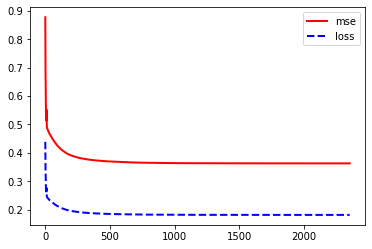

In [16]:
# Loss and MSE Plot
plt.plot(range(0,len(mses)), mses, color='red', linewidth=2, label="mse")
plt.plot(range(0,len(mses)), losses, color='blue', linewidth=2, linestyle='dashed', label="loss")
plt.legend()

### Best Model

In [5]:
# 5x34 (batch = 0)
batch = 0
width = 34
depth = 5

INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 0.75

nodes = [INPUT_SIZE] + [width for i in range(depth)] + [OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]
nn = NeuralNetwork()

losses, mses = nn.fit(X = X_train_normalize,
                      y = y_train_normalize,
                      n_hidden = len(nodes) - 2,
                      nodes = nodes,
                      activations = activations,
                      lr = LEARNING_RATE,
                      validation_X = X_val_normalize,
                      validation_y = y_val_normalize,
                      batch_size = batch)

# RESULTS
## loss = 0.179
## mse = 0.359


loss:
0.44620972960082206
mse:
0.8924194592016441

loss:
0.4459729193626126
mse:
0.8919458387252251

loss:
0.44567167713180245
mse:
0.8913433542636049

loss:
0.44546972769007903
mse:
0.8909394553801581

loss:
0.44529022842881993
mse:
0.8905804568576399

loss:
0.44510899580166546
mse:
0.8902179916033309

loss:
0.4449180595967546
mse:
0.8898361191935092

loss:
0.4447114838694545
mse:
0.889422967738909

loss:
0.4444633287625074
mse:
0.8889266575250148

loss:
0.4441741340061069
mse:
0.8883482680122138

loss:
0.44385014375004644
mse:
0.8877002875000929

loss:
0.4434727430788194
mse:
0.8869454861576388

loss:
0.4430308215548943
mse:
0.8860616431097886

loss:
0.44251204365370533
mse:
0.8850240873074107

loss:
0.44190695642688815
mse:
0.8838139128537763

loss:
0.441185847408111
mse:
0.882371694816222

loss:
0.440304278470736
mse:
0.880608556941472

loss:
0.4390698878598955
mse:
0.878139775719791

loss:
0.43716835363031853
mse:
0.8743367072606371

loss:
0.43497720790378336
mse:
0.8699544158075


loss:
0.232861483363539
mse:
0.465722966727078

loss:
0.2325487127908661
mse:
0.4650974255817322

loss:
0.2322382880422956
mse:
0.4644765760845912

loss:
0.23192868103278522
mse:
0.46385736206557043

loss:
0.2316210406667328
mse:
0.4632420813334656

loss:
0.23131709123454558
mse:
0.46263418246909116

loss:
0.2310165759003405
mse:
0.462033151800681

loss:
0.2307186932751207
mse:
0.4614373865502414

loss:
0.23042323793417038
mse:
0.46084647586834077

loss:
0.23012957970121964
mse:
0.4602591594024393

loss:
0.2298362103422979
mse:
0.4596724206845958

loss:
0.229545679660905
mse:
0.45909135932181

loss:
0.229253944371672
mse:
0.458507888743344

loss:
0.2289659564969573
mse:
0.4579319129939146

loss:
0.22868005598911778
mse:
0.45736011197823556

loss:
0.22839904107834458
mse:
0.45679808215668916

loss:
0.2281200593702199
mse:
0.4562401187404398

loss:
0.2278433194254579
mse:
0.4556866388509158

loss:
0.22756738661692863
mse:
0.45513477323385726

loss:
0.22729332213235423
mse:
0.45458664426


loss:
0.20575126914994665
mse:
0.4115025382998933

loss:
0.20569256216032647
mse:
0.41138512432065294

loss:
0.2056338886418708
mse:
0.4112677772837416

loss:
0.20557541059998974
mse:
0.4111508211999795

loss:
0.20551704279670568
mse:
0.41103408559341137

loss:
0.20545843712405895
mse:
0.4109168742481179

loss:
0.20539987549240066
mse:
0.4107997509848013

loss:
0.20534142782591103
mse:
0.41068285565182205

loss:
0.20528298945542517
mse:
0.41056597891085034

loss:
0.20522466077030735
mse:
0.4104493215406147

loss:
0.20516645031986483
mse:
0.41033290063972966

loss:
0.2051082973580879
mse:
0.4102165947161758

loss:
0.2050501751503234
mse:
0.4101003503006468

loss:
0.20499246658112955
mse:
0.4099849331622591
Annealing learning rate. New rate is 0.036320670843750014

loss:
0.20494068075015465
mse:
0.4098813615003093

loss:
0.20488896750730523
mse:
0.40977793501461046

loss:
0.20483708692657948
mse:
0.40967417385315896

loss:
0.20478535404946246
mse:
0.40957070809892493

loss:
0.2047335492


loss:
0.198895416564749
mse:
0.397790833129498
Annealing learning rate. New rate is 0.023829992140584386

loss:
0.19886547334900917
mse:
0.39773094669801834

loss:
0.1988354937298387
mse:
0.3976709874596774

loss:
0.19880561933343407
mse:
0.39761123866686815

loss:
0.19877572946456032
mse:
0.39755145892912064

loss:
0.19874586453946022
mse:
0.39749172907892044

loss:
0.1987162463033888
mse:
0.3974324926067776

loss:
0.1986865111615706
mse:
0.3973730223231412

loss:
0.19865685042359355
mse:
0.3973137008471871

loss:
0.1986272450329843
mse:
0.3972544900659686

loss:
0.19859760843545793
mse:
0.39719521687091586

loss:
0.19856797348714297
mse:
0.39713594697428595

loss:
0.1985384884074006
mse:
0.3970769768148012

loss:
0.1985089194584032
mse:
0.3970178389168064

loss:
0.19847938670190887
mse:
0.39695877340381774

loss:
0.1984498877865217
mse:
0.3968997755730434

loss:
0.19842037834867984
mse:
0.3968407566973597

loss:
0.19839111023751224
mse:
0.3967822204750245

loss:
0.19836181497001193



loss:
0.19519640622303944
mse:
0.3903928124460789

loss:
0.19517887389124347
mse:
0.39035774778248694

loss:
0.19516135097419332
mse:
0.39032270194838664

loss:
0.19514384069636134
mse:
0.3902876813927227

loss:
0.19512631755585766
mse:
0.3902526351117153

loss:
0.19510879572258877
mse:
0.39021759144517754

loss:
0.19509130458439086
mse:
0.3901826091687817

loss:
0.19507380251032141
mse:
0.39014760502064283

loss:
0.19505631202451104
mse:
0.3901126240490221

loss:
0.19503883698061347
mse:
0.39007767396122695

loss:
0.1950213783374332
mse:
0.3900427566748664

loss:
0.1950039685159554
mse:
0.3900079370319108

loss:
0.19498653232151364
mse:
0.3899730646430273

loss:
0.19496912281393414
mse:
0.3899382456278683

loss:
0.19495177512067144
mse:
0.3899035502413429

loss:
0.19493445924805747
mse:
0.38986891849611494

loss:
0.19491713279336717
mse:
0.38983426558673434

loss:
0.19489987027820627
mse:
0.38979974055641253

loss:
0.1948825674653
mse:
0.3897651349306

loss:
0.1948652620393204
mse:
0


loss:
0.19301888073649826
mse:
0.3860377614729965

loss:
0.19300818243660386
mse:
0.38601636487320773

loss:
0.1929975072401563
mse:
0.3859950144803126

loss:
0.19298688891378327
mse:
0.38597377782756653

loss:
0.19297623873002803
mse:
0.38595247746005606

loss:
0.19296559019451612
mse:
0.38593118038903224

loss:
0.19295501355247963
mse:
0.38591002710495925

loss:
0.19294438251775833
mse:
0.38588876503551667

loss:
0.19293378737445116
mse:
0.3858675747489023

loss:
0.19292318283734106
mse:
0.3858463656746821

loss:
0.1929126355595116
mse:
0.3858252711190232

loss:
0.19290205866006724
mse:
0.3858041173201345
Annealing learning rate. New rate is 0.009232227207971361

loss:
0.1928925740729969
mse:
0.3857851481459938

loss:
0.19288312846603992
mse:
0.38576625693207983

loss:
0.19287366588007232
mse:
0.38574733176014464

loss:
0.1928641904813579
mse:
0.3857283809627158

loss:
0.19285480340237543
mse:
0.38570960680475086

loss:
0.19284538446782495
mse:
0.3856907689356499

loss:
0.1928359673


loss:
0.19175943474471766
mse:
0.3835188694894353

loss:
0.19175361174851946
mse:
0.3835072234970389

loss:
0.19174779307955206
mse:
0.3834955861591041

loss:
0.1917419497463062
mse:
0.3834838994926124

loss:
0.19173612844579088
mse:
0.38347225689158176

loss:
0.19173029422309762
mse:
0.38346058844619524

loss:
0.1917244738466291
mse:
0.3834489476932582

loss:
0.1917186263940915
mse:
0.383437252788183

loss:
0.1917128305947301
mse:
0.3834256611894602

loss:
0.1917069914508495
mse:
0.383413982901699

loss:
0.1917011994068809
mse:
0.3834023988137618

loss:
0.191695373039253
mse:
0.383390746078506

loss:
0.1916895927860446
mse:
0.3833791855720892

loss:
0.19168378072855816
mse:
0.3833675614571163

loss:
0.19167799781972295
mse:
0.3833559956394459

loss:
0.1916721977439902
mse:
0.3833443954879804

loss:
0.19166644422936727
mse:
0.38333288845873453

loss:
0.19166065007298647
mse:
0.38332130014597293

loss:
0.1916549047120962
mse:
0.3833098094241924

loss:
0.19164913733798125
mse:
0.3832982


loss:
0.19101306289703773
mse:
0.38202612579407547

loss:
0.19100948359525272
mse:
0.38201896719050543

loss:
0.19100588923974732
mse:
0.38201177847949463

loss:
0.19100230778103836
mse:
0.3820046155620767

loss:
0.19099871106983302
mse:
0.38199742213966603

loss:
0.19099514518726732
mse:
0.38199029037453464

loss:
0.19099158040441652
mse:
0.38198316080883304

loss:
0.19098799171024028
mse:
0.38197598342048056

loss:
0.1909844247159959
mse:
0.3819688494319918

loss:
0.19098084071480279
mse:
0.38196168142960557

loss:
0.19097726976636795
mse:
0.3819545395327359

loss:
0.1909737108570796
mse:
0.3819474217141592

loss:
0.190970128366357
mse:
0.381940256732714

loss:
0.19096655714341274
mse:
0.38193311428682547

loss:
0.19096297911531937
mse:
0.38192595823063874

loss:
0.19095943141804908
mse:
0.38191886283609816

loss:
0.1909558508874486
mse:
0.3819117017748972

loss:
0.19095230332609814
mse:
0.3819046066521963

loss:
0.19094876740295252
mse:
0.38189753480590505

loss:
0.1909451978183907


loss:
0.19056418821538434
mse:
0.3811283764307687

loss:
0.19056190054876498
mse:
0.38112380109752997

loss:
0.19055959537372769
mse:
0.38111919074745537

loss:
0.19055730226602668
mse:
0.38111460453205337

loss:
0.1905550008506079
mse:
0.3811100017012158

loss:
0.19055271096756113
mse:
0.38110542193512226

loss:
0.19055042539362574
mse:
0.3811008507872515

loss:
0.1905481260603597
mse:
0.3810962521207194

loss:
0.19054584392652665
mse:
0.3810916878530533

loss:
0.19054354746442662
mse:
0.38108709492885323

loss:
0.19054126743317973
mse:
0.38108253486635946
Annealing learning rate. New rate is 0.0023467082859311658

loss:
0.19053921175224992
mse:
0.38107842350449983

loss:
0.1905371459037842
mse:
0.3810742918075684

loss:
0.1905350946865427
mse:
0.3810701893730854

loss:
0.19053302970500016
mse:
0.3810660594100003

loss:
0.19053097839216082
mse:
0.38106195678432164

loss:
0.1905289178967998
mse:
0.3810578357935996

loss:
0.1905268651582394
mse:
0.3810537303164788

loss:
0.190524816483


loss:
0.19028742905753426
mse:
0.3805748581150685

loss:
0.1902861132598943
mse:
0.3805722265197886

loss:
0.19028479725488393
mse:
0.38056959450976785

loss:
0.19028347293158324
mse:
0.3805669458631665

loss:
0.19028215896313555
mse:
0.3805643179262711

loss:
0.19028083660964618
mse:
0.38056167321929235

loss:
0.19027952172270932
mse:
0.38055904344541863

loss:
0.1902782086682494
mse:
0.3805564173364988

loss:
0.19027688795108602
mse:
0.38055377590217204

loss:
0.19027557392344766
mse:
0.3805511478468953

loss:
0.19027426197319833
mse:
0.38054852394639666

loss:
0.19027294177860787
mse:
0.38054588355721575

loss:
0.19027162861114452
mse:
0.38054325722228904

loss:
0.19027030929286964
mse:
0.3805406185857393

loss:
0.19026899575403397
mse:
0.38053799150806794

loss:
0.19026768295268073
mse:
0.38053536590536147

loss:
0.19026636330765773
mse:
0.38053272661531545

loss:
0.19026504980416192
mse:
0.38053009960832385

loss:
0.19026372970288588
mse:
0.38052745940577176

loss:
0.190262417769


loss:
0.190115597152848
mse:
0.380231194305696

loss:
0.1901147474340307
mse:
0.3802294948680614

loss:
0.19011389150137173
mse:
0.38022778300274346

loss:
0.190113042054458
mse:
0.380226084108916

loss:
0.19011218594175772
mse:
0.38022437188351543

loss:
0.1901113365433594
mse:
0.3802226730867188

loss:
0.19011048166398017
mse:
0.38022096332796035

loss:
0.19010963134655615
mse:
0.3802192626931123

loss:
0.1901087765978715
mse:
0.380217553195743

loss:
0.1901079264787272
mse:
0.3802158529574544

loss:
0.190107071953014
mse:
0.380214143906028

loss:
0.1901062225364707
mse:
0.3802124450729414

loss:
0.19010536706493888
mse:
0.38021073412987777

loss:
0.19010451837701742
mse:
0.38020903675403483

loss:
0.1901036679865593
mse:
0.3802073359731186

loss:
0.19010281337390025
mse:
0.3802056267478005

loss:
0.19010196384339845
mse:
0.3802039276867969

loss:
0.19010110885639772
mse:
0.38020221771279544

loss:
0.19010026074968323
mse:
0.38020052149936645

loss:
0.1900994062702713
mse:
0.3801988


loss:
0.19000712725238064
mse:
0.3800142545047613

loss:
0.1900065767781313
mse:
0.3800131535562626

loss:
0.19000602269221792
mse:
0.38001204538443584

loss:
0.19000547151540995
mse:
0.3800109430308199

loss:
0.1900049176929714
mse:
0.3800098353859428

loss:
0.19000436678513694
mse:
0.38000873357027387

loss:
0.19000381250909773
mse:
0.38000762501819546

loss:
0.19000326176013624
mse:
0.3800065235202725

loss:
0.19000270781165593
mse:
0.38000541562331186

loss:
0.19000215343798477
mse:
0.38000430687596953

loss:
0.19000160324319246
mse:
0.3800032064863849
Annealing learning rate. New rate is 0.0005965017601064953

loss:
0.1900011048929945
mse:
0.380002209785989

loss:
0.1900006092024944
mse:
0.3800012184049888

loss:
0.19000011090075158
mse:
0.38000022180150317

loss:
0.1899996152597618
mse:
0.3799992305195236

loss:
0.1899991169568394
mse:
0.3799982339136788

loss:
0.18999862107127458
mse:
0.37999724214254915

loss:
0.1899981226914492
mse:
0.3799962453828984

loss:
0.189997627653286


loss:
0.18993986406973568
mse:
0.37987972813947135

loss:
0.1899395403863131
mse:
0.3798790807726262

loss:
0.18993921633864166
mse:
0.37987843267728333

loss:
0.18993889040273407
mse:
0.37987778080546813

loss:
0.1899385663855157
mse:
0.3798771327710314

loss:
0.18993824055225844
mse:
0.3798764811045169

loss:
0.18993791686588377
mse:
0.37987583373176753

loss:
0.18993759281733974
mse:
0.3798751856346795

loss:
0.1899372670827567
mse:
0.3798745341655134

loss:
0.1899369434292433
mse:
0.3798738868584866

loss:
0.18993661724827876
mse:
0.3798732344965575

loss:
0.18993629372669638
mse:
0.37987258745339275

loss:
0.1899359697201966
mse:
0.3798719394403932

loss:
0.18993564397306445
mse:
0.3798712879461289

loss:
0.18993532043247707
mse:
0.37987064086495415

loss:
0.18993499436197273
mse:
0.37986998872394545

loss:
0.18993467086809768
mse:
0.37986934173619535

loss:
0.1899343473388263
mse:
0.3798686946776526

loss:
0.18993402127293496
mse:
0.3798680425458699

loss:
0.189933697878292
mse:


loss:
0.18989736775697635
mse:
0.3797947355139527

loss:
0.18989715643122462
mse:
0.37979431286244925

loss:
0.1898969433519395
mse:
0.379793886703879

loss:
0.18989673185373634
mse:
0.3797934637074727

loss:
0.1898965189940877
mse:
0.3797930379881754

loss:
0.1898963073640114
mse:
0.3797926147280228

loss:
0.18989609594571866
mse:
0.3797921918914373

loss:
0.18989588323086581
mse:
0.37979176646173163

loss:
0.18989567165265256
mse:
0.3797913433053051

loss:
0.189895460357777
mse:
0.379790920715554

loss:
0.1898952473363052
mse:
0.3797904946726104

loss:
0.18989503602275956
mse:
0.3797900720455191

loss:
0.18989482469707464
mse:
0.3797896493941493

loss:
0.18989461173364952
mse:
0.37978922346729904

loss:
0.18989440039795405
mse:
0.3797888007959081

loss:
0.189894189099833
mse:
0.379788378199666

loss:
0.1898939760982549
mse:
0.3797879521965098

loss:
0.1898937648075774
mse:
0.3797875296151548

loss:
0.18989355350703555
mse:
0.3797871070140711

loss:
0.18989334053723247
mse:
0.3797866


loss:
0.18987029849722298
mse:
0.37974059699444596

loss:
0.18987015899883913
mse:
0.37974031799767827

loss:
0.1898700206218565
mse:
0.379740041243713

loss:
0.18986988131303179
mse:
0.37973976262606357

loss:
0.1898697427767453
mse:
0.3797394855534906

loss:
0.189869604398819
mse:
0.379739208797638

loss:
0.18986946493703313
mse:
0.37973892987406627

loss:
0.18986932656051136
mse:
0.37973865312102273

loss:
0.18986918820389972
mse:
0.37973837640779945

loss:
0.18986904870137727
mse:
0.37973809740275455

loss:
0.18986891032907927
mse:
0.37973782065815853
Annealing learning rate. New rate is 0.00015162274405528035

loss:
0.18986878498675772
mse:
0.37973756997351543

loss:
0.1898686602823767
mse:
0.3797373205647534

loss:
0.18986853577643764
mse:
0.3797370715528753

loss:
0.18986841039749308
mse:
0.37973682079498616

loss:
0.18986828573970965
mse:
0.3797365714794193

loss:
0.1898681611828725
mse:
0.379736322365745

loss:
0.18986803568436086
mse:
0.37973607136872173

loss:
0.18986791116

In [6]:
# Predict on Train
predictions = nn.predict(X_test_normalize)
test_mse = ((predictions - y_test_normalize) ** 2).mean()
test_mse

price_doc    0.596636
dtype: float64

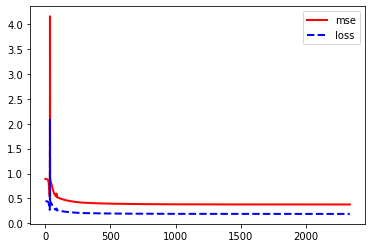

In [7]:
# Loss and MSE Plot
plt.plot(range(0,len(mses)), mses, color='red', linewidth=2, label="mse")
plt.plot(range(0,len(mses)), losses, color='blue', linewidth=2, linestyle='dashed', label="loss")
plt.legend()

In [ ]:
# 7x34 (batch = 0)
batch = 0
width = 34
depth = 7

INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 3

nodes = [INPUT_SIZE] + [width for i in range(depth)] + [OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]
nn = NeuralNetwork()

losses, mses = nn.fit(X = X_train_normalize,
                      y = y_train_normalize,
                      n_hidden = len(nodes) - 2,
                      nodes = nodes,
                      activations = activations,
                      lr = LEARNING_RATE,
                      validation_X = X_val_normalize,
                      validation_y = y_val_normalize,
                      batch_size = batch)

# RESULTS
## loss = 0.193
## mse = 0.386


loss:
0.4460701957551899
mse:
0.8921403915103798

loss:
0.4460129374070761
mse:
0.8920258748141522

loss:
0.4459125824992098
mse:
0.8918251649984196

loss:
0.4462645991384278
mse:
0.8925291982768556
INCREASE IN LOSS

loss:
0.44670867619925153
mse:
0.8934173523985031
INCREASE IN LOSS
Decreasing learning rate. New rate is 1.5

loss:
0.4465448495181969
mse:
0.8930896990363938

loss:
0.44597777857272564
mse:
0.8919555571454513

loss:
0.44616062992185623
mse:
0.8923212598437125
INCREASE IN LOSS


In [ ]:
# 8x34 (batch = 0)
batch = 0
width = 34
depth = 8

INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 3

nodes = [INPUT_SIZE] + [width for i in range(depth)] + [OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]
nn = NeuralNetwork()

losses, mses = nn.fit(X = X_train_normalize,
                      y = y_train_normalize,
                      n_hidden = len(nodes) - 2,
                      nodes = nodes,
                      activations = activations,
                      lr = LEARNING_RATE,
                      validation_X = X_val_normalize,
                      validation_y = y_val_normalize,
                      batch_size = batch)

# RESULTS
## loss = 0.192
## mse = 0.383

In [ ]:
# 10x34 (batch = 0)
batch = 0
width = 34
depth = 10

INPUT_SIZE = X_train_normalize.shape[1]
OUTPUT_SIZE = 1
LEARNING_RATE = 4

nodes = [INPUT_SIZE] + [width for i in range(depth)] + [OUTPUT_SIZE]
activations = ["relu" for i in range(len(nodes))]
nn = NeuralNetwork()

losses, mses = nn.fit(X = X_train_normalize,
                      y = y_train_normalize,
                      n_hidden = len(nodes) - 2,
                      nodes = nodes,
                      activations = activations,
                      lr = LEARNING_RATE,
                      validation_X = X_val_normalize,
                      validation_y = y_val_normalize,
                      batch_size = batch)

# RESULTS
## loss = 0.186
## mse = 0.372

In [ ]:
def solve_for_B(x, y, n):
    # takes a data frame, and a numpy array
    x = np.concatenate((np.ones((n,1)), x.to_numpy()), axis=1)
    x_transpose = np.transpose(x)
    return np.linalg.solve(np.matmul(x_transpose, x), x_transpose @ y)

def get_predicted_values(beta, design_matrix, n):
    return np.matmul(np.concatenate((np.ones((n,1)), design_matrix), axis = 1), beta)

def BIC(predictions, actuals, d, n):
    # numpy array - predictions, numpy array - actual 
    return (np.square(actuals - predictions).sum()) + (d * np.log(n))

def RSquaredAdj(predictions, actuals, d, n):
    x1 = np.square(actuals - actuals.mean()).sum()
    x2 = np.square(predictions - actuals.mean()).sum()
    r2 = x2/x1
    return (1 - ((1 - r2) * (n - 1) / (n - d - 1)))

def RMSE(predictions, actuals, n):
    return np.sqrt((np.square(actuals - predictions).sum()) / n) 

def train_model(design_matrix, dependent_variable_series):
    n = design_matrix.shape[0]
    beta = solve_for_B(design_matrix, dependent_variable_series, n)
    predicted_values = get_predicted_values(beta, design_matrix, n)
    calculated_BIC = BIC(predicted_values, dependent_variable_series, d = design_matrix.shape[1], n = n)
    calculated_RMSE = RMSE(predicted_values, dependent_variable_series, n = n)
    residuals = predicted_values - dependent_variable_series
    return beta, calculated_BIC, calculated_RMSE, residuals

In [ ]:
def train_crossv_model(df, y): 
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(.25 * m)
    train_1 = df.iloc[perm[:train_end]]
    test_1 = y.iloc[perm[:train_end]]

    train_2 = df.iloc[perm[train_end:train_end*2]]
    test_2 = y.iloc[perm[train_end:train_end*2]]

    train_3 = df.iloc[perm[train_end*2:train_end*3]]
    test_3 = y.iloc[perm[train_end*2:train_end*3]]

    train_4 = df.iloc[perm[train_end*3:]]
    test_4 = y.iloc[perm[train_end*3:]]
    return train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4


def get_average_RMSE_for_one_model(df, y):
    train_1, test_1, train_2, test_2, train_3, test_3, train_4, test_4 = train_crossv_model(df, y)

    beta4, bic4, RMSE4, _ = train_model(train_1.append([train_2, train_3]), test_1.append([test_2, test_3]))

    beta2, bic3,RMSE2, _ = train_model(train_1.append([train_4, train_3]), test_1.append([test_4, test_3]))

    beta3, bic2, RMSE3, _ = train_model(train_1.append([train_2, train_4]), test_1.append([test_2, test_4]))

    beta1, bic1, RMSE1, _ = train_model(train_4.append([train_2, train_3]), test_4.append([test_2, test_3]))

    return sum([RMSE1, RMSE2, RMSE3, RMSE4]) / 4, sum([bic1, bic2, bic3, bic4]) / 4


In [ ]:
# forward cross validated stepwise

train_data = X_train.copy()
df_with_col = pd.DataFrame()

#min_RMSE, min_bic = get_average_RMSE_for_one_model(train_data, y_train_sample)

col_added = []
rmses = []

for i in range(0,50):

    min_col = None
    min_RMSE = 100000000000000000000
    min_bic = 10000000000000000000

    for col in train_data.columns:

        df_with_col[col] = train_data[col]
        
        new_RMSE, new_bic = get_average_RMSE_for_one_model(df_with_col, y_train)
                
        if new_RMSE[0] <= min_RMSE:
            min_bic = new_bic[0]
            min_RMSE = new_RMSE[0]
            min_col = col
            
        df_with_col.drop(columns=[col], inplace=True)

    if min_col is not None:
        print(min_col)
        df_with_col[min_col] = train_data[min_col]
        train_data.drop(columns=[min_col], inplace=True)
        rmses.append(min_RMSE)
        print("bic: " + str(min_bic))
        print("rmse: " + str(min_RMSE))
        col_added.append(min_col)
        print("")
    else:
        print("Failed #2")


In [ ]:
# RMSEs
plt.plot(range(0,50), rmses)

In [ ]:
col_added